Loading the datasets

In [155]:
%pip install fuzzywuzzy
import pandas as pd
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

# Load CSV files
gsm_dataset = pd.read_csv('/Users/adamj/Desktop/bda_proj/2024_GSM_parsed.csv')
user_dataset = pd.read_csv('/Users/adamj/Desktop/bda_proj/user_behavior_dataset.csv')


# Drop the columns 'brand' and 'model' from gsm_datasets since they have NaN values
gsm_dataset = gsm_dataset.drop(columns=['brand', 'model'])

print(gsm_dataset.head())
print(user_dataset.head())

Note: you may need to restart the kernel to use updated packages.
                         id        date    year  display_size_inches  \
0           Apple iPhone 12  2020-10-23  2020.0                 6.10   
1            Google Pixel 5  2020-10-15  2020.0                 6.00   
2                 OnePlus 9  2021-03-26  2021.0                 6.55   
3              Xiaomi Mi 11  2021-01-01  2021.0                 6.81   
4  Samsung Galaxy S21 FE 5G  2022-01-07  2022.0                 6.40   

   internal_memory_in_gb  primary_camera_mega_pixel  \
0                   64.0                       12.0   
1                  128.0                        2.0   
2                  128.0                       48.0   
3                  128.0                      108.0   
4                  128.0                       12.0   

                                      primary_camera  \
0  12 MP, f/1.6, 26mm (wide), 1.4µm, dual pixel P...   
1  12.2 MP, f/1.7, 27mm (wide), 1/2.55", 1.4µm, d...   
2 

Elasticsearch and Kibana

In [156]:
!pip install docker

Running Elastisearch and Kibana

In [157]:
import docker
import time

client = docker.from_env()

try:
    container = client.containers.get('user_behavior_es')
    container.stop()
    container.remove()
    print("'user_behavior_es' removed.")
except docker.errors.NotFound:
    print("'user_behavior_es' not found.")

try:
    container = client.containers.get('user_behavior_kibana')
    container.stop()
    container.remove()
    print("'user_behavior_kibana' removed.")
except docker.errors.NotFound:
    print("'user_behavior_kibana' not found.")
    
    
try:
    network = client.networks.get('elastic')
    network.remove()
    print("'elastic' removed.")
except docker.errors.NotFound:
    print("'elastic' not found. Creating a new network.")

client.networks.create('elastic', driver="bridge")

es_container = client.containers.run(
    image='docker.elastic.co/elasticsearch/elasticsearch:7.12.1',
    name='user_behavior_es',
    environment={'discovery.type': 'single-node'},
    ports={'9200': 9200, '9300': 9300},
    network='elastic',
    detach=True
)

kibana_container = client.containers.run(
    image='docker.elastic.co/kibana/kibana:7.12.1',
    name='user_behavior_kibana',
    environment={'ELASTICSEARCH_HOSTS': 'http://user_behavior_es:9200'},
    ports={'5601': 5601},
    network='elastic',
    detach=True
)

print("Elasticsearch and Kibana running.")


'user_behavior_es' removed.
'user_behavior_kibana' removed.
'elastic' removed.
Elasticsearch and Kibana running.


Preparing the dataset to be uploaded

In [160]:
import pandas as pd
import json

def prepare_bulk_upload(dataframe, index_name):
    lines = []
    for idx, record in dataframe.iterrows():
        metadata = {"index": {"_index": index_name, "_id": idx}}
        lines.append(metadata)
        lines.append(record.to_dict())
    return lines

lines = prepare_bulk_upload(user_dataset, 'user_behavior')

with open('user_behavior_bulk.json', 'w') as file:
    for line in lines:
        file.write(json.dumps(line) + '\n')

        
print("Data prepared for bulk upload to Elasticsearch.")


Data prepared for bulk upload to Elasticsearch.


Uploading data to elasticsearch

In [166]:
import requests

try:
    response = requests.get('http://localhost:9200')
    response.raise_for_status()
    print("Elasticsearch is running.")
except requests.exceptions.RequestException as e:
    print(f"Error connecting to Elasticsearch: {e}")
    raise

with open('user_behavior_bulk.json', 'r') as file:
    data = file.read()
       
response = requests.post(
    'http://localhost:9200/_bulk',
    data=data,
    headers={'Content-Type': 'application/x-ndjson'}
)

print(response.status_code)


Elasticsearch is running.
200


Running queries (Elasticsearch)

Amount of users per device?

Device: Apple iPhone 12, Users: 146 (20.86%)
Device: Xiaomi Mi 11, Users: 146 (20.86%)
Device: Google Pixel 5, Users: 142 (20.29%)
Device: OnePlus 9, Users: 133 (19.00%)
Device: Samsung Galaxy S21 5G, Users: 133 (19.00%)


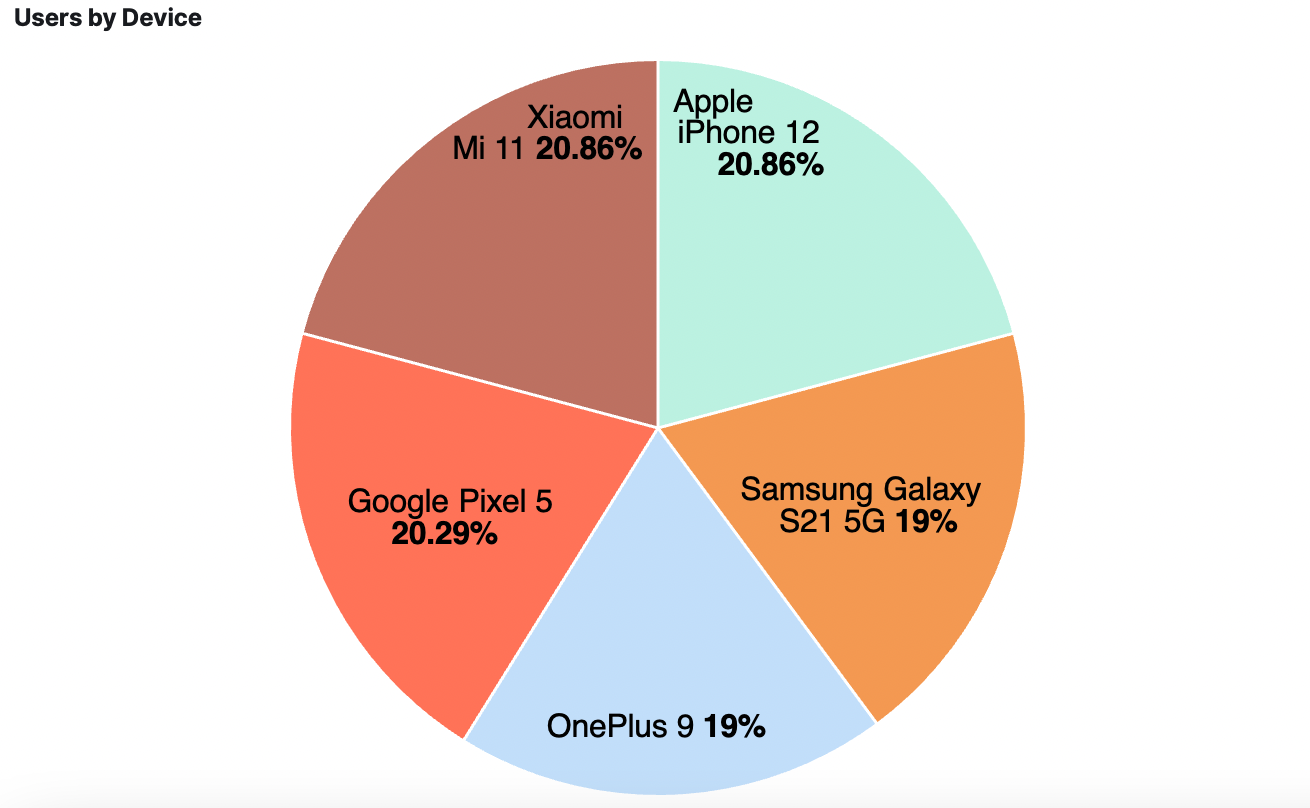

In [167]:
from IPython.display import Image, display

agg_query = {
    "size": 0, 
    "aggs": {
        "devices": {
            "terms": {
                "field": "Device Model.keyword", 
                "size": 5 
            }
        }
    }
}

response = requests.post(
    'http://localhost:9200/user_behavior/_search?pretty',  
    json=agg_query,
    headers={'Content-Type': 'application/json'}
)

if response.status_code == 200:
    response_json = response.json()
    devices = response_json['aggregations']['devices']['buckets']
    
    total_users = sum(device['doc_count'] for device in devices)
    
    for device in devices:
        device_name = device['key']
        user_count = device['doc_count']
        percentage = (user_count / total_users) * 100
        print(f"Device: {device_name}, Users: {user_count} ({percentage:.2f}%)")
else:
    print(f"Error: {response.status_code}")
    print(response.text)
    
display(Image(filename='/Users/adamj/Desktop/bda_proj/images/device.png'))

What devices do female and males use and to what extent?

Device: Apple iPhone 12
  Female: 74
  Male: 72
Device: Xiaomi Mi 11
  Female: 78
  Male: 68
Device: Google Pixel 5
  Male: 73
  Female: 69
Device: OnePlus 9
  Male: 72
  Female: 61
Device: Samsung Galaxy S21 5G
  Male: 79
  Female: 54


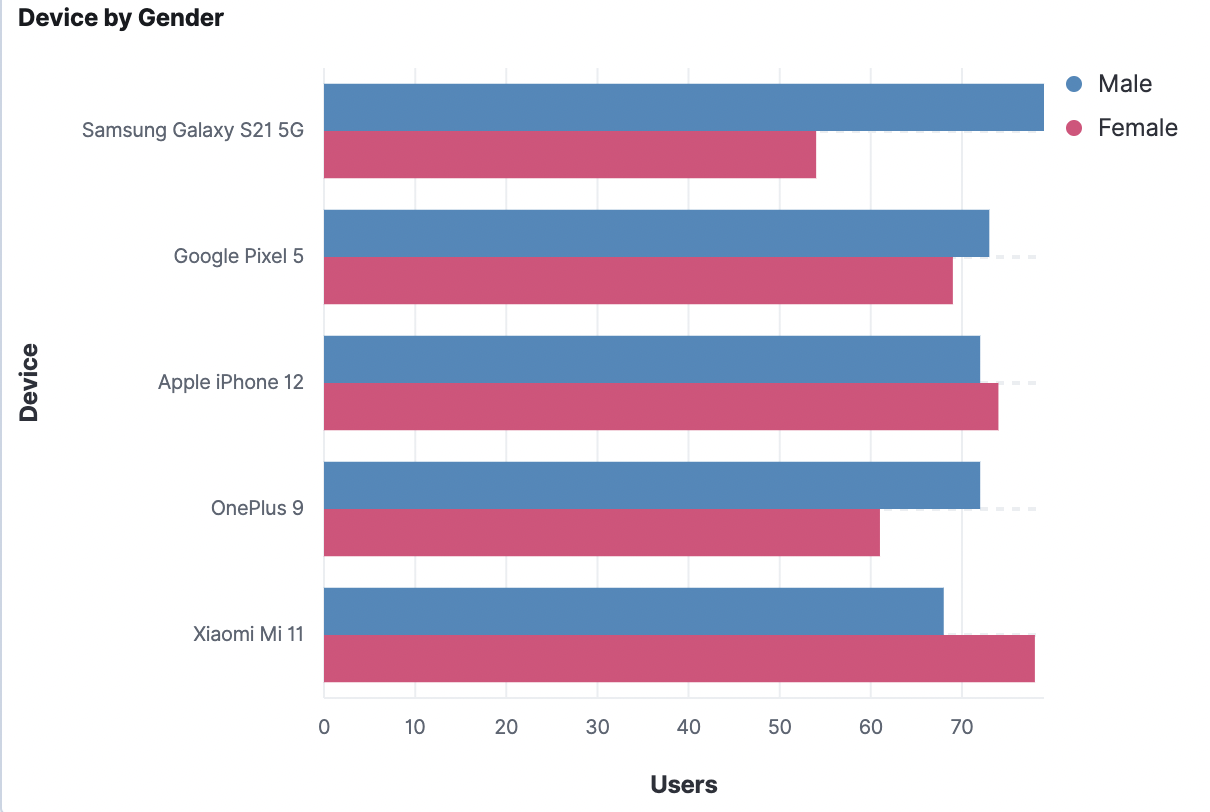

In [168]:
agg_query = {
    "size": 0, 
    "aggs": {
        "devices": {
            "terms": {
                "field": "Device Model.keyword", 
                "size": 5  
            },
            "aggs": {
                "gender_split": {
                    "terms": {
                        "field": "Gender.keyword",
                        "size": 2  
                    }
                }
            }
        }
    }
}

response = requests.post(
    'http://localhost:9200/user_behavior/_search?pretty',  
    json=agg_query,
    headers={'Content-Type': 'application/json'}
)

if response.status_code == 200:
    response_json = response.json()
    devices = response_json['aggregations']['devices']['buckets']
    
    for device in devices:
        device_name = device['key']
        gender_buckets = device['gender_split']['buckets']
        gender_counts = {gender['key']: gender['doc_count'] for gender in gender_buckets}
        print(f"Device: {device_name}")
        for gender, count in gender_counts.items():
            print(f"  {gender}: {count}")
else:
    print(f"Error: {response.status_code}")
    print(response.text)
    
display(Image(filename='/Users/adamj/Desktop/bda_proj/images/gender.png'))

What devices do different age groups use and to what extent?

Device: Apple iPhone 12
  Age Group 18-29: 34
  Age Group 30-39: 32
  Age Group 40-49: 28
  Age Group 50-59: 36
Device: Xiaomi Mi 11
  Age Group 18-29: 40
  Age Group 30-39: 33
  Age Group 40-49: 30
  Age Group 50-59: 27
Device: Google Pixel 5
  Age Group 18-29: 40
  Age Group 30-39: 35
  Age Group 40-49: 23
  Age Group 50-59: 34
Device: OnePlus 9
  Age Group 18-29: 33
  Age Group 30-39: 26
  Age Group 40-49: 33
  Age Group 50-59: 31
Device: Samsung Galaxy S21 5G
  Age Group 18-29: 35
  Age Group 30-39: 23
  Age Group 40-49: 28
  Age Group 50-59: 33


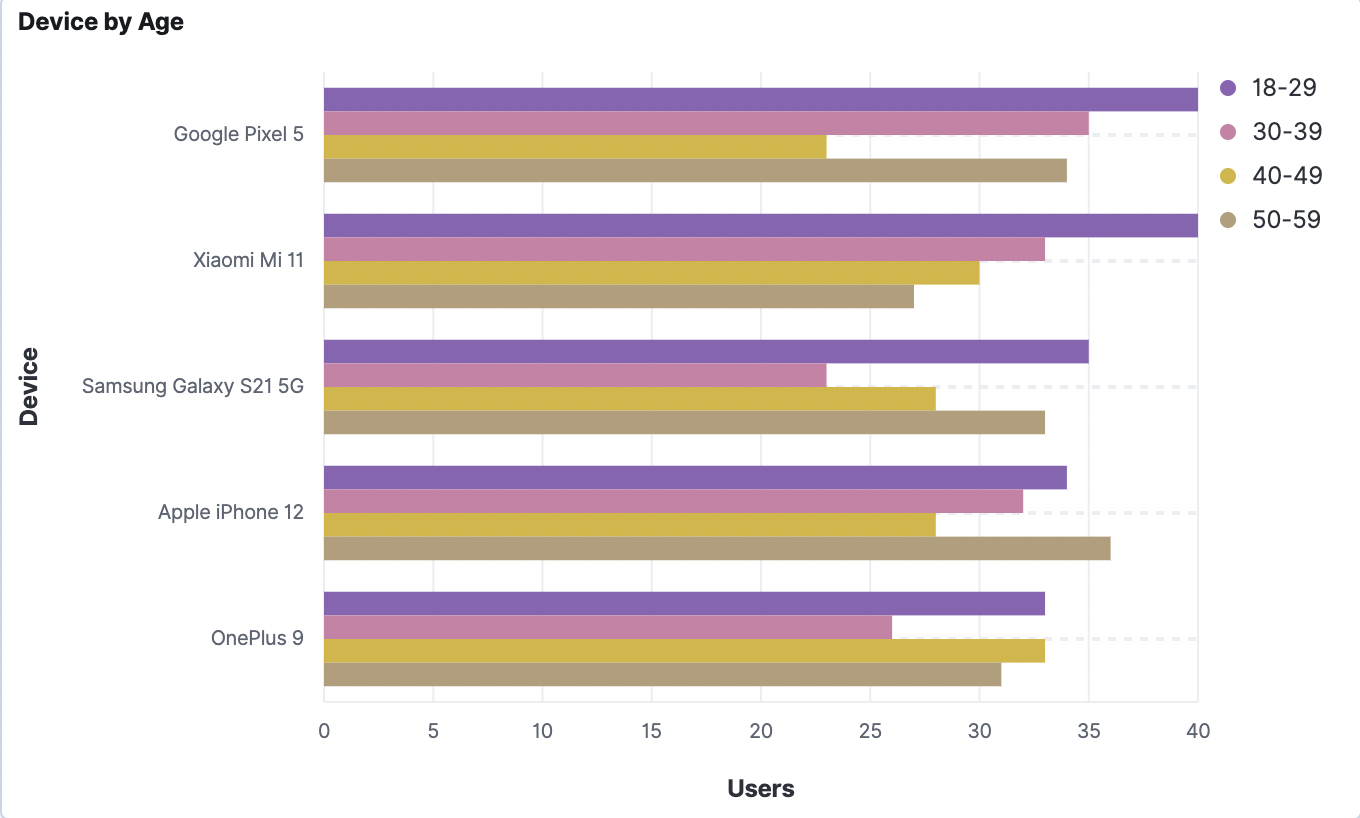

In [169]:
agg_query = {
    "size": 0, 
    "aggs": {
        "devices": {
            "terms": {
                "field": "Device Model.keyword", 
                "size": 5  
            },
            "aggs": {
                "age_groups": {
                    "range": {
                        "field": "Age",
                        "ranges": [
                            {"key": "18-29", "from": 18, "to": 29},
                            {"key": "30-39", "from": 30, "to": 39},
                            {"key": "40-49", "from": 40, "to": 49},
                            {"key": "50-59", "from": 50, "to": 59}
                        ]
                    }
                }
            }
        }
    }
}

response = requests.post(
    'http://localhost:9200/user_behavior/_search?pretty',  
    json=agg_query,
    headers={'Content-Type': 'application/json'}
)

if response.status_code == 200:
    response_json = response.json()
    devices = response_json['aggregations']['devices']['buckets']
    
    for device in devices:
        device_name = device['key']
        age_buckets = device['age_groups']['buckets']
        age_counts = {age['key']: age['doc_count'] for age in age_buckets}
        print(f"Device: {device_name}")
        for age_group, count in age_counts.items():
            print(f"  Age Group {age_group}: {count}")
else:
    print(f"Error: {response.status_code}")
    print(response.text)

display(Image(filename='/Users/adamj/Desktop/bda_proj/images/age.png'))

App usage time, screen on time, battery drain, data usage by gender?

In [170]:
agg_query = {
    "size": 0,
    "aggs": {
        "gender": {
            "terms": {
                "field": "Gender.keyword",
                "size": 2  
            },
            "aggs": {
                "app_usage_time": {
                    "avg": {
                        "field": "App Usage Time (min/day)"
                    }
                },
                "screen_on_time": {
                    "avg": {
                        "field": "Screen On Time (hours/day)"
                    }
                },
                "battery_drain": {
                    "avg": {
                        "field": "Battery Drain (mAh/day)"
                    }
                },
                "data_usage": {
                    "avg": {
                        "field": "Data Usage (MB/day)"
                    }
                }
            }
        }
    }
}

response = requests.post(
    'http://localhost:9200/user_behavior/_search?pretty',
    json=agg_query,
    headers={'Content-Type': 'application/json'}
)

if response.status_code == 200:
    response_json = response.json()
    genders = response_json['aggregations']['gender']['buckets']
    
    for gender in genders:
        gender_name = gender['key']
        app_usage_time = gender['app_usage_time']['value']
        screen_on_time = gender['screen_on_time']['value']
        battery_drain = gender['battery_drain']['value']
        data_usage = gender['data_usage']['value']
        
        print(f"Gender: {gender_name}")
        print(f"  App Usage Time (min/day): {app_usage_time}")
        print(f"  Screen On Time (hours/day): {screen_on_time}")
        print(f"  Battery Drain (mAh/day): {battery_drain}")
        print(f"  Data Usage (MB/day): {data_usage}")
else:
    print(f"Error: {response.status_code}")
    print(response.text)

Gender: Male
  App Usage Time (min/day): 270.3543956043956
  Screen On Time (hours/day): 5.28324175797976
  Battery Drain (mAh/day): 1530.0906593406594
  Data Usage (MB/day): 943.978021978022
Gender: Female
  App Usage Time (min/day): 271.9672619047619
  Screen On Time (hours/day): 5.261309511249974
  Battery Drain (mAh/day): 1519.8154761904761
  Data Usage (MB/day): 914.3214285714286


App usage time, screen on time, battery drain, data usage by age?

In [212]:
agg_query = {
    "size": 0,
    "aggs": {
        "age_groups": {
            "range": {
                "field": "Age",
                "ranges": [
                    {"key": "18-29", "from": 18, "to": 29},
                    {"key": "30-39", "from": 30, "to": 39},
                    {"key": "40-49", "from": 40, "to": 49},
                    {"key": "50-59", "from": 50, "to": 59}
                ]
            },
            "aggs": {
                "app_usage_time": {
                    "avg": {
                        "field": "App Usage Time (min/day)"
                    }
                },
                "screen_on_time": {
                    "avg": {
                        "field": "Screen On Time (hours/day)"
                    }
                },
                "battery_drain": {
                    "avg": {
                        "field": "Battery Drain (mAh/day)"
                    }
                },
                "data_usage": {
                    "avg": {
                        "field": "Data Usage (MB/day)"
                    }
                }
            }
        }
    }
}

response = requests.post(
    'http://localhost:9200/user_behavior/_search?pretty',
    json=agg_query,
    headers={'Content-Type': 'application/json'}
)

if response.status_code == 200:
    response_json = response.json()
    age_groups = response_json['aggregations']['age_groups']['buckets']
    
    for age_group in age_groups:
        age_group_name = age_group['key']
        app_usage_time = age_group['app_usage_time']['value']
        screen_on_time = age_group['screen_on_time']['value']
        battery_drain = age_group['battery_drain']['value']
        data_usage = age_group['data_usage']['value']
        
        print(f"Age Group: {age_group_name}")
        print(f"  App Usage Time (min/day): {app_usage_time}")
        print(f"  Screen On Time (hours/day): {screen_on_time}")
        print(f"  Battery Drain (mAh/day): {battery_drain}")
        print(f"  Data Usage (MB/day): {data_usage}")
else:
    print(f"Error: {response.status_code}")
    print(response.text)

Age Group: 18-29
  App Usage Time (min/day): 275.14285714285717
  Screen On Time (hours/day): 5.291758222239358
  Battery Drain (mAh/day): 1559.3241758241759
  Data Usage (MB/day): 940.7087912087912
Age Group: 30-39
  App Usage Time (min/day): 270.38255033557044
  Screen On Time (hours/day): 5.227516781563727
  Battery Drain (mAh/day): 1504.489932885906
  Data Usage (MB/day): 940.6644295302013
Age Group: 40-49
  App Usage Time (min/day): 263.8098591549296
  Screen On Time (hours/day): 5.153521137338289
  Battery Drain (mAh/day): 1484.5774647887324
  Data Usage (MB/day): 889.5633802816901
Age Group: 50-59
  App Usage Time (min/day): 271.832298136646
  Screen On Time (hours/day): 5.328571426202052
  Battery Drain (mAh/day): 1532.4037267080746
  Data Usage (MB/day): 921.8322981366459


Merging the datasets

In [172]:
merged_dataset = pd.merge(user_dataset, gsm_dataset, left_on='Device Model', right_on='id', how='inner')

#dropping this since it is identifcal to the 'Device Model' column
merged_dataset = merged_dataset.drop(columns=['id'])

print("\nMerged Dataset:")
print(merged_dataset.head())

merged_dataset.to_csv('/Users/adamj/Desktop/bda_proj/merged_dataset.csv', index=False)
print("Merged dataset saved to merged_dataset.csv")


Merged Dataset:
   User ID     Device Model Operating System  App Usage Time (min/day)  \
0        1   Google Pixel 5          Android                       393   
1        2        OnePlus 9          Android                       268   
2        3     Xiaomi Mi 11          Android                       154   
3        4   Google Pixel 5          Android                       239   
4        5  Apple iPhone 12              iOS                       187   

   Screen On Time (hours/day)  Battery Drain (mAh/day)  \
0                         6.4                     1872   
1                         4.7                     1331   
2                         4.0                      761   
3                         4.8                     1676   
4                         4.3                     1367   

   Number of Apps Installed  Data Usage (MB/day)  Age  Gender  ...  \
0                        67                 1122   40    Male  ...   
1                        42                  944 

Queries on merged dataset

Average display size by genders

   Gender  display_size_inches
0  Female             6.342054
1    Male             6.323297


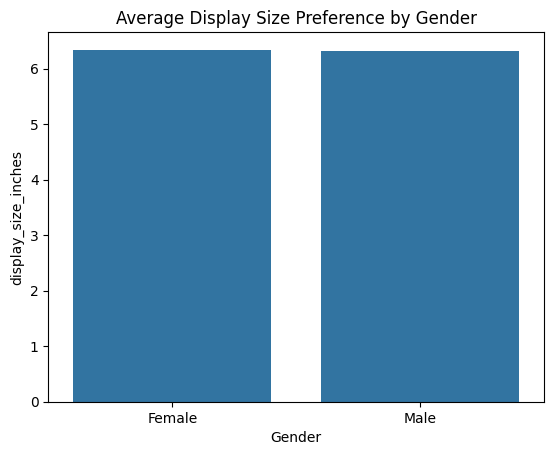

In [173]:
gender_group = merged_dataset.groupby('Gender').agg({
    'display_size_inches': 'mean',  
}).reset_index()

print(gender_group)

sns.barplot(x='Gender', y='display_size_inches', data=gender_group)
plt.title('Average Display Size Preference by Gender')
plt.show()

Average battery capacity by genders

   Gender  battery_mah
0  Female  3985.505952
1    Male  3992.637363


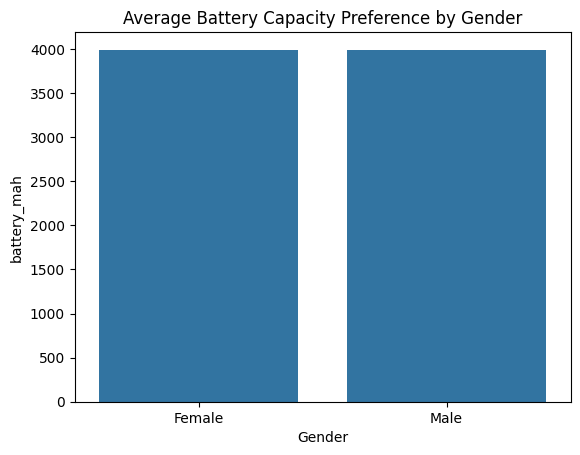

In [174]:
gender_group = merged_dataset.groupby('Gender').agg({
    'battery_mah': 'mean',  
}).reset_index()

print(gender_group)

sns.barplot(x='Gender', y='battery_mah', data=gender_group)
plt.title('Average Battery Capacity Preference by Gender')
plt.show()

Average RAM capacity by gender

   Gender  ram_in_gb
0  Female   6.654762
1    Male   6.835165


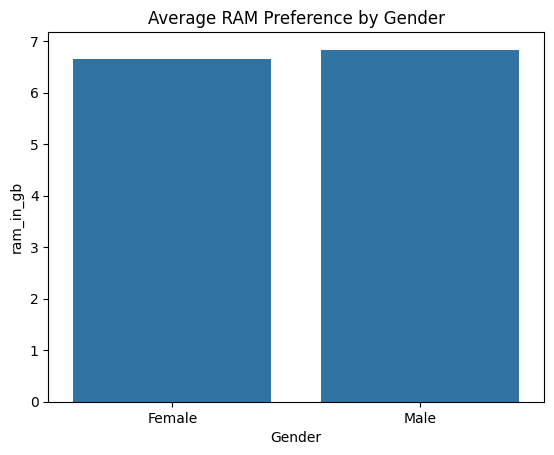

In [175]:
gender_group = merged_dataset.groupby('Gender').agg({ 
    'ram_in_gb': 'mean',  
}).reset_index()

print(gender_group)

sns.barplot(x='Gender', y='ram_in_gb', data=gender_group)
plt.title('Average RAM Preference by Gender')
plt.show()


Average camera mega pixel by gender

   Gender  primary_camera_mega_pixel
0  Female                  38.767857
1    Male                  35.049451


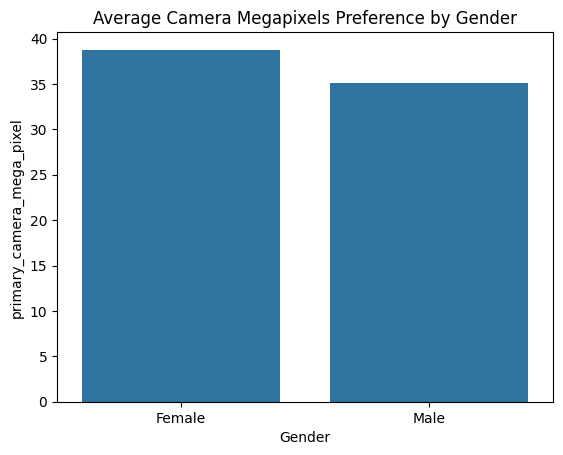

In [176]:
gender_group = merged_dataset.groupby('Gender').agg({ 
    'primary_camera_mega_pixel': 'mean', 
}).reset_index()

print(gender_group)

sns.barplot(x='Gender', y='primary_camera_mega_pixel', data=gender_group)
plt.title('Average Camera Megapixels Preference by Gender')
plt.show()

Color preferences by gender

   Gender                                             colors
0  Female  Horizon Blue, Cloud White, Midnight Gray, Spec...
1    Male  Phantom Gray, Phantom White, Phantom Violet, P...


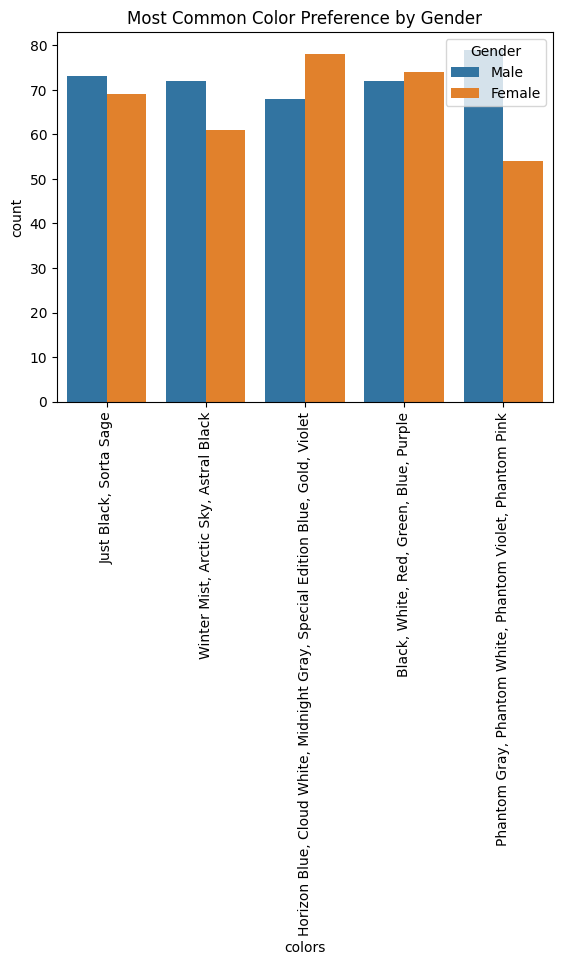

In [177]:
gender_group = merged_dataset.groupby('Gender').agg({ 
    'colors': lambda x: x.mode()[0] 
}).reset_index()

print(gender_group)

sns.countplot(x='colors', hue='Gender', data=merged_dataset)
plt.xticks(rotation=90)
plt.title('Most Common Color Preference by Gender')
plt.show()

Internal memory by gender

   Gender  internal_memory_in_gb
0  Female             113.904762
1    Male             115.340659


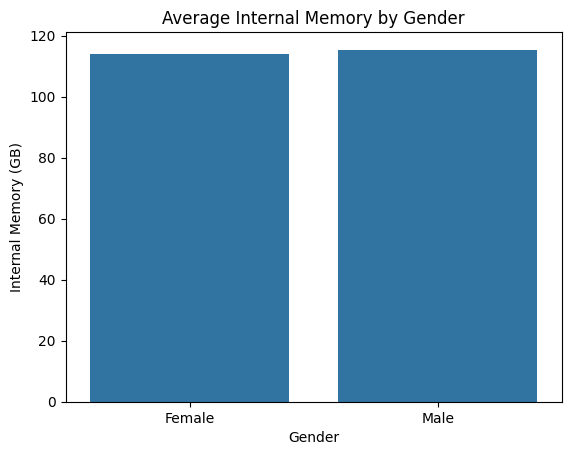

In [178]:
gender_group = merged_dataset.groupby('Gender').agg({
    'internal_memory_in_gb': 'mean',  
}).reset_index()

print(gender_group)

sns.barplot(x='Gender', y='internal_memory_in_gb', data=gender_group)
plt.title('Average Internal Memory by Gender')
plt.xlabel('Gender')
plt.ylabel('Internal Memory (GB)')
plt.show()


GPS by gender

GPS Preferences by Gender:
   Gender                                                gps  Count
0  Female  GPS (L1+L5), GLONASS (G1), BDS (B1), GALILEO (...     61
1  Female  GPS (L1+L5), GLONASS (G1), BDS (B1I+B1c+B2a), ...     78
2  Female                         GPS, GLONASS, BDS, GALILEO     54
3  Female                        GPS, GLONASS, GALILEO, QZSS     74
4  Female                   GPS, GLONASS, GALILEO, QZSS, BDS     69
5    Male  GPS (L1+L5), GLONASS (G1), BDS (B1), GALILEO (...     72
6    Male  GPS (L1+L5), GLONASS (G1), BDS (B1I+B1c+B2a), ...     68
7    Male                         GPS, GLONASS, BDS, GALILEO     79
8    Male                        GPS, GLONASS, GALILEO, QZSS     72
9    Male                   GPS, GLONASS, GALILEO, QZSS, BDS     73


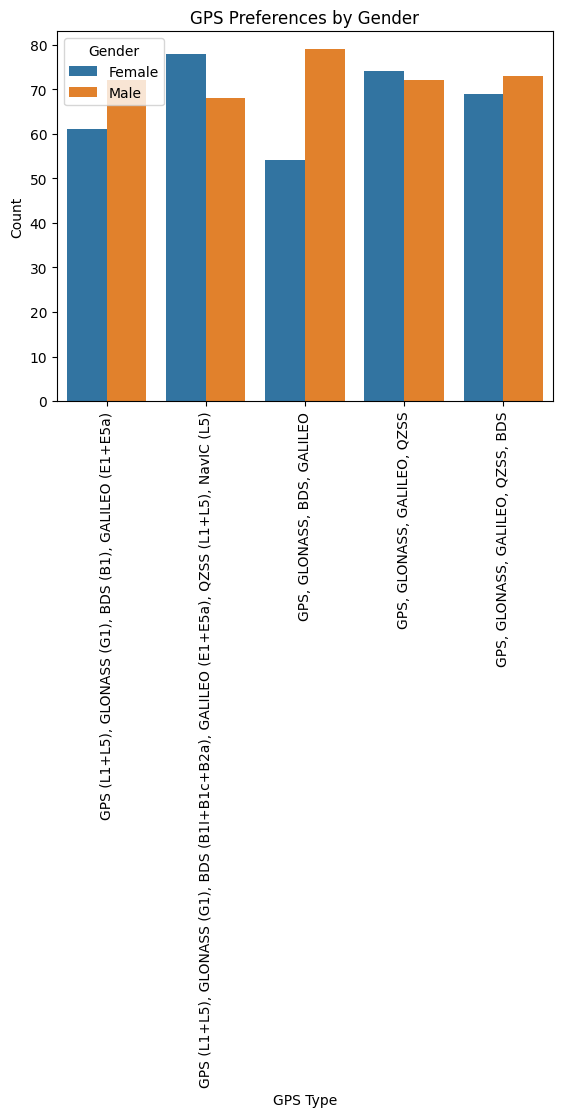

In [179]:
gps_by_gender = merged_dataset.groupby(['Gender', 'gps']).size().reset_index(name='Count')

print("GPS Preferences by Gender:")
print(gps_by_gender)

sns.barplot(x='gps', y='Count', hue='Gender', data=gps_by_gender)
plt.title('GPS Preferences by Gender')
plt.xlabel('GPS Type')
plt.ylabel('Count')
plt.xticks(rotation=90) 
plt.show()


Approx price by gender

   Gender  approx_price_eur
0  Female        237.353125
1    Male        239.397747


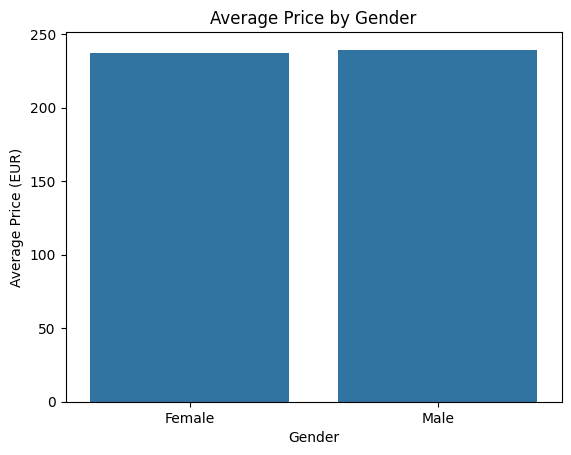

In [180]:
gender_group = merged_dataset.groupby('Gender').agg({
    'approx_price_eur': 'mean',  
}).reset_index()

print(gender_group)

sns.barplot(x='Gender', y='approx_price_eur', data=gender_group)
plt.title('Average Price by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Price (EUR)')
plt.show()

Release year by gender

   Gender    year
0  Female  2021.0
1    Male  2021.0


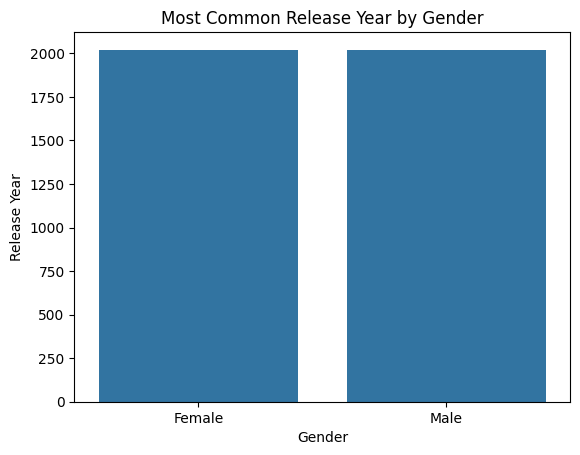

In [181]:
from statistics import mode

gender_group = merged_dataset.groupby('Gender').agg({
    'year': mode,  
}).reset_index()

print(gender_group)

sns.barplot(x='Gender', y='year', data=gender_group)
plt.title('Most Common Release Year by Gender')
plt.xlabel('Gender')
plt.ylabel('Release Year')
plt.show()


Both genders have devices released 2021 on average, however the dataset is limited to devices from 2020-2021. 

  age_group  display_size_inches
0     18-29             6.334890
1     30-39             6.332235
2     40-49             6.345605
3     50-59             6.315337


/var/folders/kt/3pmdv0dx0_93jplm_mz4_b9m0000gn/T/ipykernel_32845/3950025931.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group = merged_dataset.groupby('age_group').agg({


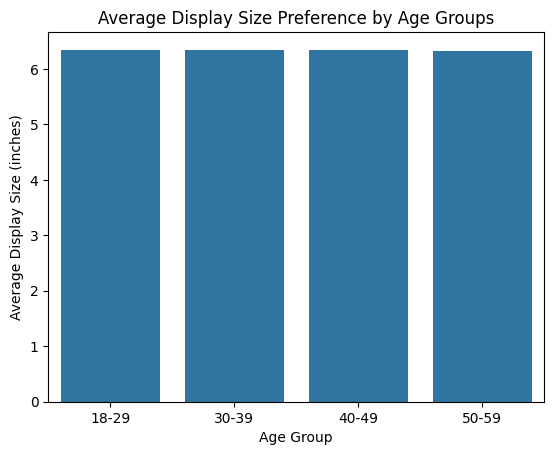

In [182]:
age_bins = [18, 29, 39, 49, 59]
age_labels = ['18-29', '30-39', '40-49', '50-59']
merged_dataset['age_group'] = pd.cut(merged_dataset['Age'], bins=age_bins, labels=age_labels, right=False)

age_group = merged_dataset.groupby('age_group').agg({
    'display_size_inches': 'mean',  
}).reset_index()

print(age_group)

sns.barplot(x='age_group', y='display_size_inches', data=age_group)
plt.title('Average Display Size Preference by Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Average Display Size (inches)')
plt.show()

  age_group         year  display_size_inches  internal_memory_in_gb  \
0     18-29  2020.593407             6.334890             116.043956   
1     30-39  2020.558824             6.332235             113.694118   
2     40-49  2020.630573             6.345605             114.547771   
3     50-59  2020.573034             6.315337             114.696629   

   primary_camera_mega_pixel  approx_price_eur  battery_mah  ram_in_gb  
0                  37.428571        235.570934  4018.736264   6.813187  
1                  37.635294        237.209059  3974.882353   6.658824  
2                  37.388535        241.805987  3993.598726   6.764331  
3                  34.483146        238.530000  3977.949438   6.797753  


/var/folders/kt/3pmdv0dx0_93jplm_mz4_b9m0000gn/T/ipykernel_32845/783736629.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_metrics = merged_dataset.groupby('age_group').agg(metrics).reset_index()
/var/folders/kt/3pmdv0dx0_93jplm_mz4_b9m0000gn/T/ipykernel_32845/783736629.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y=column, data=age_group_metrics, palette='viridis')


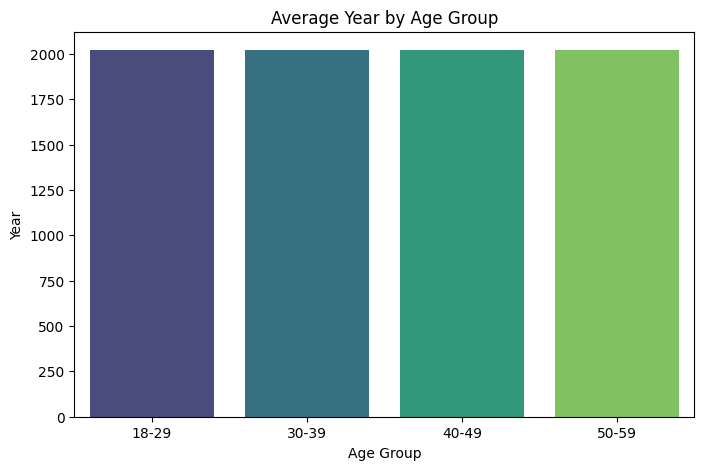

/var/folders/kt/3pmdv0dx0_93jplm_mz4_b9m0000gn/T/ipykernel_32845/783736629.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y=column, data=age_group_metrics, palette='viridis')


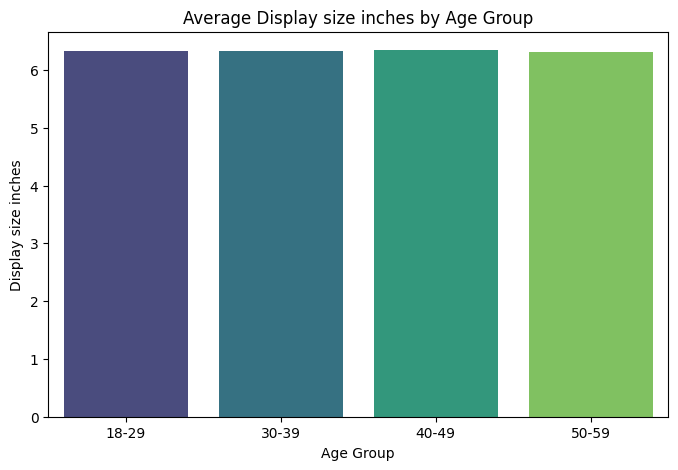

/var/folders/kt/3pmdv0dx0_93jplm_mz4_b9m0000gn/T/ipykernel_32845/783736629.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y=column, data=age_group_metrics, palette='viridis')


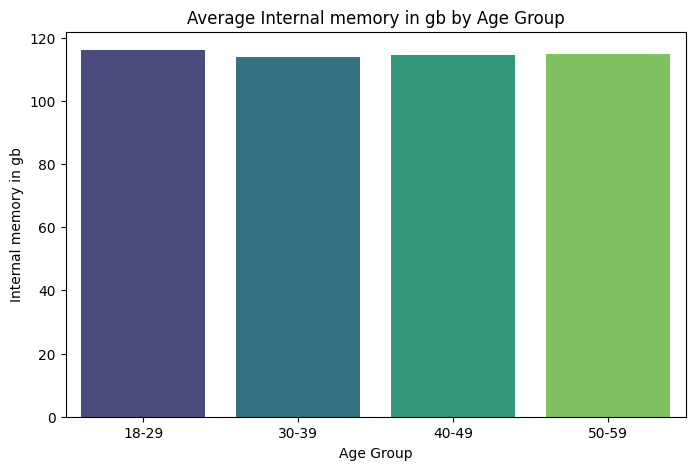

/var/folders/kt/3pmdv0dx0_93jplm_mz4_b9m0000gn/T/ipykernel_32845/783736629.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y=column, data=age_group_metrics, palette='viridis')


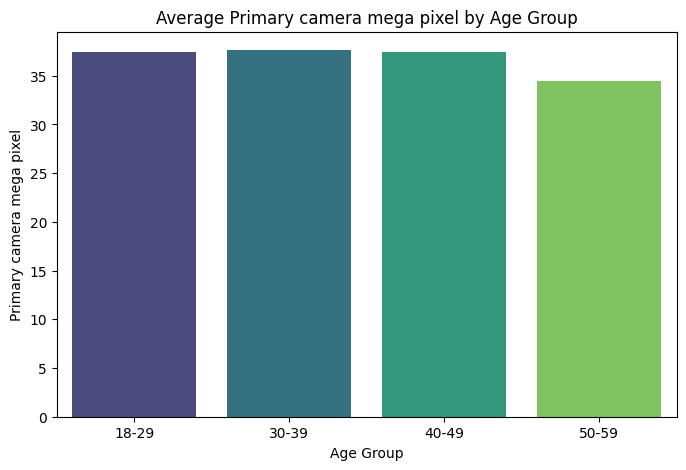

/var/folders/kt/3pmdv0dx0_93jplm_mz4_b9m0000gn/T/ipykernel_32845/783736629.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y=column, data=age_group_metrics, palette='viridis')


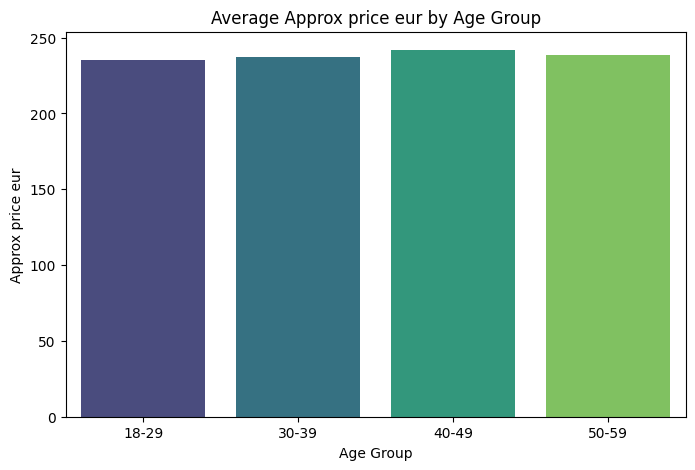

/var/folders/kt/3pmdv0dx0_93jplm_mz4_b9m0000gn/T/ipykernel_32845/783736629.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y=column, data=age_group_metrics, palette='viridis')


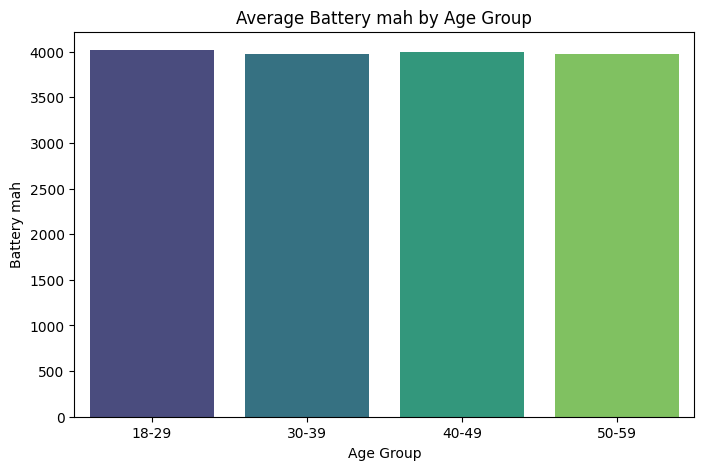

/var/folders/kt/3pmdv0dx0_93jplm_mz4_b9m0000gn/T/ipykernel_32845/783736629.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='age_group', y=column, data=age_group_metrics, palette='viridis')


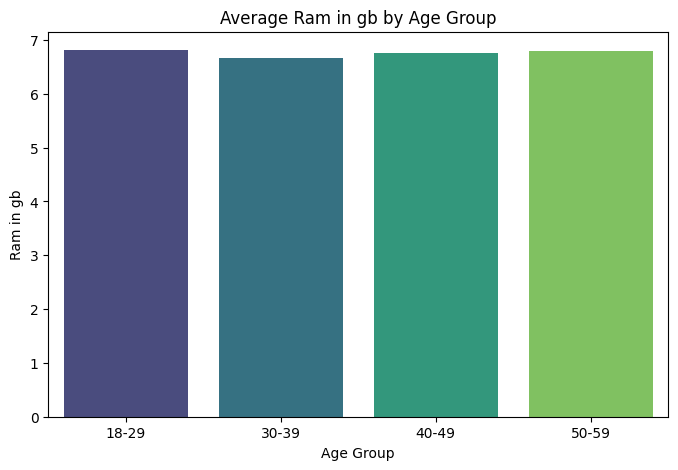

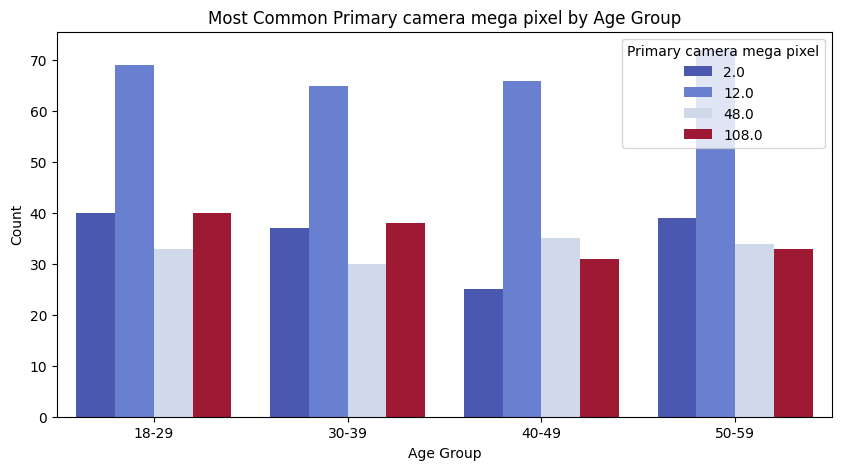

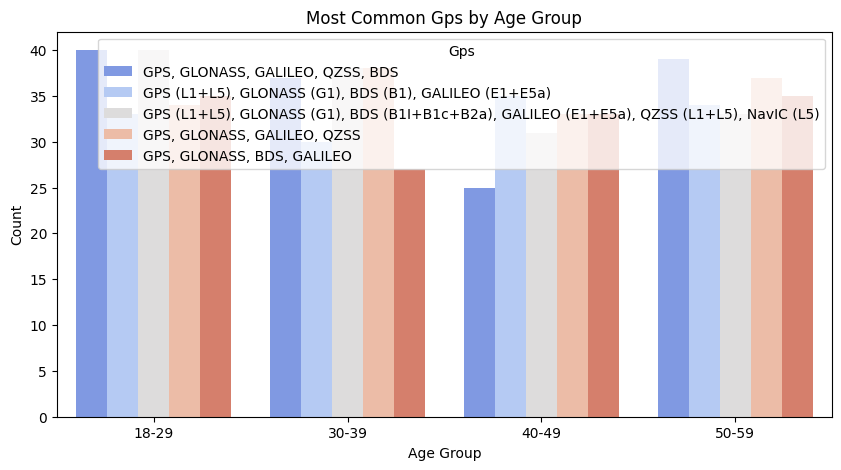

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

age_bins = [18, 29, 39, 49, 59]
age_labels = ['18-29', '30-39', '40-49', '50-59']

merged_dataset['age_group'] = pd.cut(merged_dataset['Age'], bins=age_bins, labels=age_labels, right=False)

metrics = {
    'year': 'mean',
    'display_size_inches': 'mean',
    'internal_memory_in_gb': 'mean',
    'primary_camera_mega_pixel': 'mean',
    'approx_price_eur': 'mean',
    'battery_mah': 'mean',
    'ram_in_gb': 'mean',
}

age_group_metrics = merged_dataset.groupby('age_group').agg(metrics).reset_index()
print(age_group_metrics)

for column in metrics.keys():
    plt.figure(figsize=(8, 5))
    sns.barplot(x='age_group', y=column, data=age_group_metrics, palette='viridis')
    plt.title(f'Average {column.replace("_", " ").capitalize()} by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel(column.replace("_", " ").capitalize())
    plt.xticks(rotation=0)
    plt.show()

for column in ['primary_camera_mega_pixel', 'gps']:
    plt.figure(figsize=(10, 5))
    sns.countplot(
        x='age_group',
        hue=column,
        data=merged_dataset,
        palette='coolwarm',
    )
    plt.title(f'Most Common {column.replace("_", " ").capitalize()} by Age Group')
    plt.xlabel('Age Group')
    plt.ylabel('Count')
    plt.legend(title=column.replace("_", " ").capitalize())
    plt.xticks(rotation=0)
    plt.show()


Data analysis (Hierarchical clustering)

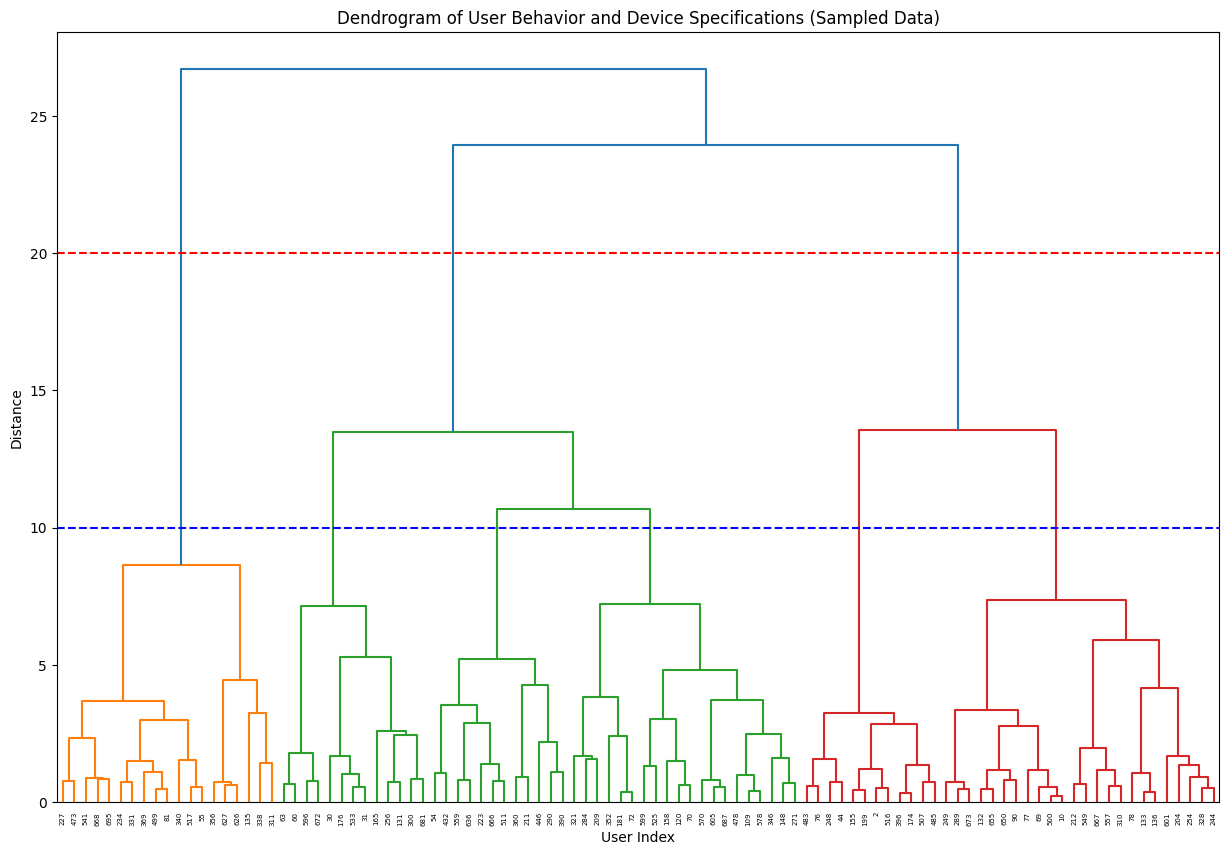

   Cluster  App Usage Time (min/day)  Screen On Time (hours/day)  \
0        1                202.052632                    4.110526   
1        2                387.533333                    7.468889   
2        3                106.861111                    2.422222   

   Battery Drain (mAh/day)  Number of Apps Installed  Data Usage (MB/day)  \
0              1213.736842                 39.473684           654.105263   
1              2112.933333                 68.644444          1303.266667   
2               717.111111                 23.916667           340.555556   

         Age  display_size_inches  internal_memory_in_gb  \
0  39.526316             6.100000                   64.0   
1  39.755556             6.449556                  128.0   
2  38.166667             6.390833                  128.0   

   primary_camera_mega_pixel  battery_mah  ram_in_gb  approx_price_eur  
0                  12.000000  2815.000000   4.000000        312.000000  
1                  49.155556  4

/var/folders/kt/3pmdv0dx0_93jplm_mz4_b9m0000gn/T/ipykernel_32845/2214259785.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=sampled_data, palette='viridis')
/var/folders/kt/3pmdv0dx0_93jplm_mz4_b9m0000gn/T/ipykernel_32845/2214259785.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=sampled_data, palette='viridis')
/var/folders/kt/3pmdv0dx0_93jplm_mz4_b9m0000gn/T/ipykernel_32845/2214259785.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y=feature, data=sampled

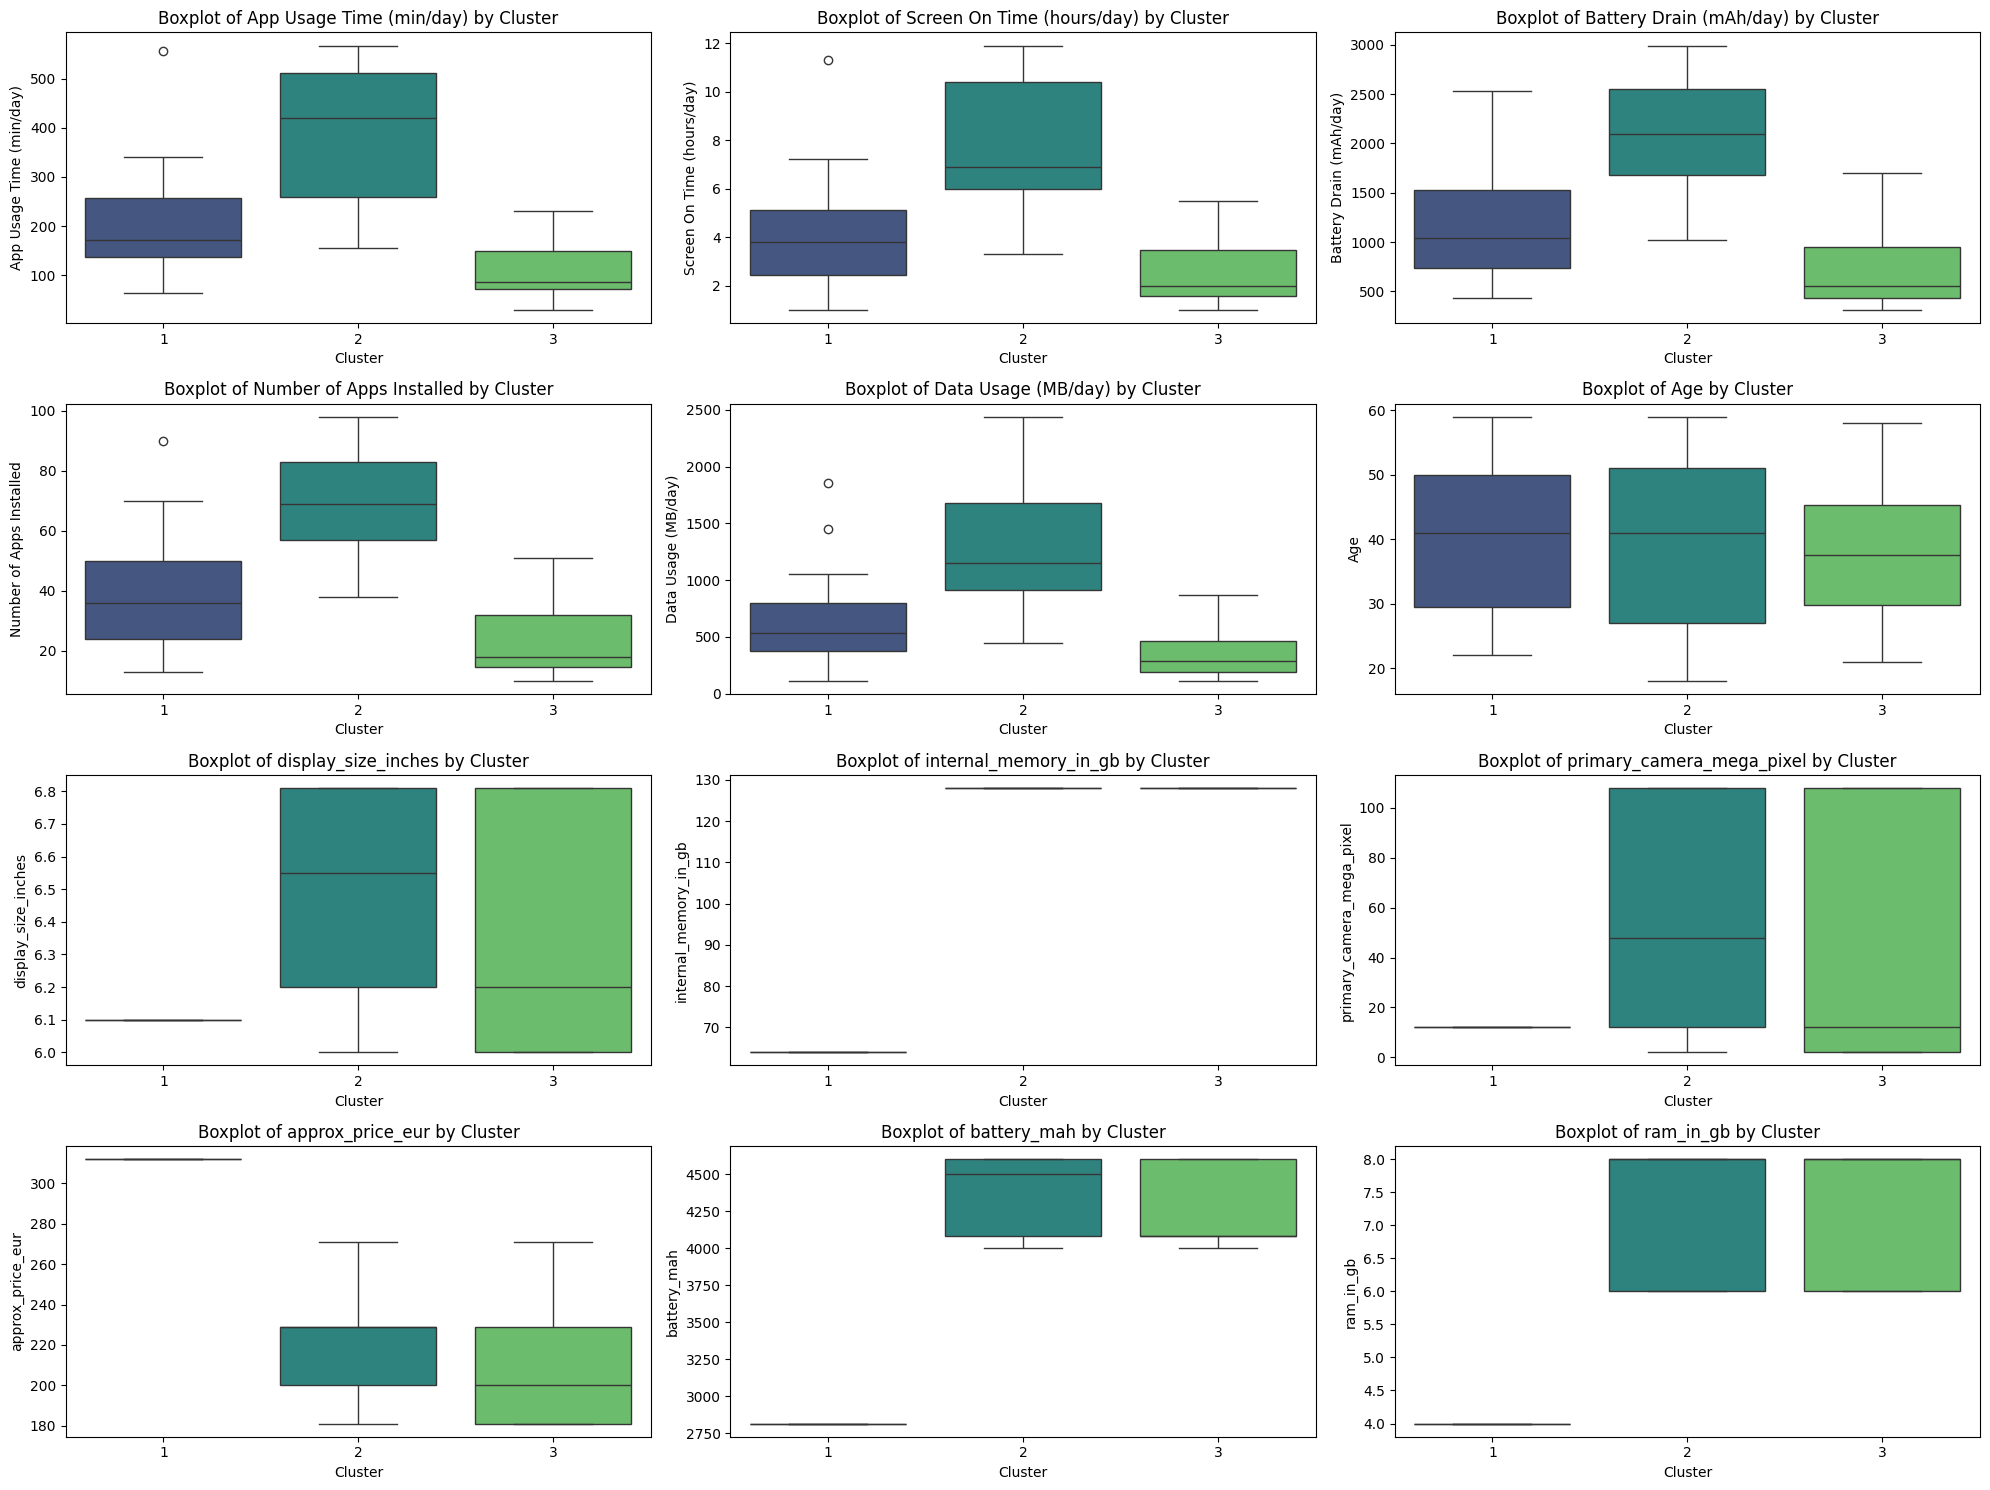

In [211]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/Users/adamj/Desktop/bda_proj/merged_dataset.csv'
merged_dataset = pd.read_csv(file_path)

sampled_data = merged_dataset.sample(n=100, random_state=42)

selected_columns = [
    'App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 
    'Number of Apps Installed', 'Data Usage (MB/day)', 'Age', 'display_size_inches', 
    'internal_memory_in_gb', 'primary_camera_mega_pixel', 'approx_price_eur', 
    'battery_mah', 'ram_in_gb'
]

clustering_data = sampled_data[selected_columns]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(clustering_data)

Z = linkage(scaled_data, method='ward')

plt.figure(figsize=(15, 10))
dendrogram(Z, labels=sampled_data.index.values, leaf_rotation=90)
plt.title('Dendrogram of User Behavior and Device Specifications (Sampled Data)')
plt.xlabel('User Index')
plt.ylabel('Distance')
plt.axhline(y=20, color='r', linestyle='--')  
plt.axhline(y=10, color='b', linestyle='--')  
plt.show()

max_d = 20  
clusters = fcluster(Z, max_d, criterion='distance')

sampled_data['Cluster'] = clusters

cluster_summary = sampled_data.groupby('Cluster').agg({
    'App Usage Time (min/day)': 'mean',
    'Screen On Time (hours/day)': 'mean',
    'Battery Drain (mAh/day)': 'mean',
    'Number of Apps Installed': 'mean',
    'Data Usage (MB/day)': 'mean',
    'Age': 'mean',
    'display_size_inches': 'mean',
    'internal_memory_in_gb': 'mean',
    'primary_camera_mega_pixel': 'mean',
    'battery_mah': 'mean',
    'ram_in_gb': 'mean',
    'approx_price_eur': 'mean'
}).reset_index()

print(cluster_summary)

features = [
    'App Usage Time (min/day)', 'Screen On Time (hours/day)', 'Battery Drain (mAh/day)', 
    'Number of Apps Installed', 'Data Usage (MB/day)', 'Age', 'display_size_inches', 
    'internal_memory_in_gb', 'primary_camera_mega_pixel', 'approx_price_eur', 
    'battery_mah', 'ram_in_gb'
]

plt.figure(figsize=(20, 15))
for i, feature in enumerate(features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(x='Cluster', y=feature, data=sampled_data, palette='viridis')
    plt.title(f'Boxplot of {feature} by Cluster')
    plt.xlabel('Cluster')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()

Demographic profiling by cluster (example on first boxplot (top right))

  Cluster Age                                     Gender
          min max       mean                    <lambda>
0       1  22  59  39.526316   {'Male': 11, 'Female': 8}
1       2  18  59  39.755556  {'Male': 26, 'Female': 19}
2       3  21  58  38.166667  {'Female': 19, 'Male': 17}


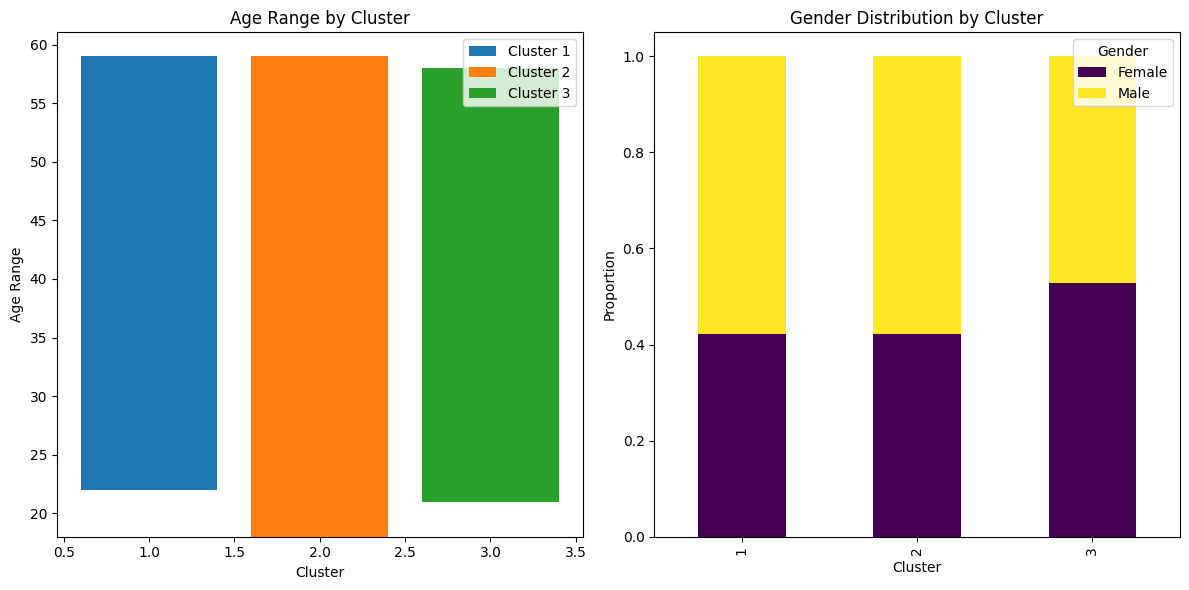

In [213]:
age_gender_summary = sampled_data.groupby('Cluster').agg({
    'Age': ['min', 'max', 'mean'],
    'Gender': lambda x: x.value_counts().to_dict()
}).reset_index()

print(age_gender_summary)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
for cluster in age_gender_summary['Cluster']:
    age_min = age_gender_summary.loc[age_gender_summary['Cluster'] == cluster, ('Age', 'min')].values[0]
    age_max = age_gender_summary.loc[age_gender_summary['Cluster'] == cluster, ('Age', 'max')].values[0]
    plt.bar(cluster, age_max - age_min, bottom=age_min, label=f'Cluster {cluster}')
plt.title('Age Range by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Age Range')
plt.legend()

plt.subplot(1, 2, 2)
gender_data = sampled_data.groupby('Cluster')['Gender'].value_counts(normalize=True).unstack().fillna(0)
gender_data.plot(kind='bar', stacked=True, ax=plt.gca(), colormap='viridis')
plt.title('Gender Distribution by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Gender')

plt.tight_layout()
plt.show()